# Similarity of cider bottle labels

The pipeline we will improve solves the very important question
as to how the type of apple used in producing a cider
impacts the label on the bottle.

In [1]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers.pipelines import pipeline
from transformers.models.auto import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer

We receive emails from farmers.
Emails are quite unstructured but we will try to figure out the
type of the apple the farmers use to produce cider.

In [2]:
emails = [
    "I've got a batch of granny smith, as crisp as they come.",
    "The best honeycrisp in tow, fresh from the orchard.",
    "Nothing compares to a red delicious, sweet and juicy.",
    "Gala apples are the best for making pies.",
    "Sweet and crisp fuji apples are my favorite.",
    "Pink lady apples are the best for snacking.",
    "Fermented apple juice is made from jonagold apples.",
    "The crisp and tart mcintosh is perfect for baking.",
    "Never heard of a braeburn apple? They're delicious.",
    "Ambrosia apples are the sweetest apples around.",
    "Cortland apples are perfect for making apple sauce.",
    "Empire apples are a cross between red delicious and mcintosh.",
    "Baking with crispin apples is a delight.",
    "From the same family as the fuji, mutsu apples are sweet and crisp.",
    "Opalescent apples are a rare treat.",
    "A barrel of rome apples incoming.",
    "Juice made from suncrisp apples is the clearest.",
    "Highest content of sugar in winesap apples.",
    "Arkansas black apples have a long shelf life.",
    "Baldwin apples are a classic.",
    "A gravenstein apple a day keeps the doctor away.",
]
emails_df = pd.DataFrame({"emails": emails})
emails_df.to_parquet("../data/emails.parquet")
emails = emails_df["emails"].tolist()
emails_df.head()

,emails
0,"I've got a batch of granny smith, as crisp as ..."
1,"The best honeycrisp in tow, fresh from the orc..."
2,"Nothing compares to a red delicious, sweet and..."
3,Gala apples are the best for making pies.
4,Sweet and crisp fuji apples are my favorite.


Types of apples are many and plenty but we will use NLI for quick
zero shot learning for the apple species.
Hence we will help the model by listing the possible apple species.

In [3]:
apple_types = [
    "granny smith",
    "honeycrisp",
    "red delicious",
    "gala",
    "fuji",
    "pink lady",
    "jonagold",
    "mcintosh",
    "braeburn",
    "ambrosia",
    "cortland",
    "empire",
    "crispin",
    "mutsu",
    "opalescent",
    "rome",
    "suncrisp",
    "winesap",
    "arkansas black",
    "baldwin",
    "gravenstein",
]
apple_types_df = pd.DataFrame({"apple_types": apple_types})
apple_types_df.to_parquet("../data/apple_types.parquet")
apple_types = apple_types_df["apple_types"].tolist()
apple_types_df.head()

,apple_types
0,granny smith
1,honeycrisp
2,red delicious
3,gala
4,fuji


In [4]:
ZERO_SHOT_TASK = "zero-shot-classification"
ZERO_SHOT_MODEL = "facebook/bart-large-mnli"
zero_shot = pipeline(ZERO_SHOT_TASK, model=ZERO_SHOT_MODEL)
zero_shot

In [5]:
infered_emails = zero_shot(emails, candidate_labels=apple_types)
len(emails), len(infered_emails)

(21, 21)

In [6]:
apples_in = [i['labels'][0] for i in infered_emails]
len(apples_in)

21

In [7]:
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2-large")
gpt2_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [8]:
@dataclass
class CiderLabel:
    apple: str
    label: str
    embedding: np.ndarray | None = None

    def __repr__(self) -> str:
        return f"CiderLabel {self.apple}: {self.label}"
    
    def __str__(self) -> str:
        return self.__repr__()

In [9]:
labels = []
for apple in apples_in:
    prompt = f"The label on a bottle of cider made out of {apple} apples reads:"
    inputs = gpt2_tokenizer(prompt, return_tensors='pt')
    input_length = inputs.input_ids.shape[1]
    outputs = gpt2_model.generate(
        **inputs,
        max_new_tokens=36,
        do_sample=True,
        temperature=0.6,
        top_p=0.7,
        top_k=10,
        return_dict_in_generate=True,
        pad_token_id=gpt2_tokenizer.eos_token_id,
    )
    token = outputs.sequences[0, input_length:]
    output_str = gpt2_tokenizer.decode(token)
    labels.append(CiderLabel(apple=apple, label=output_str))
len(labels)

21

In [10]:
embedding_model = SentenceTransformer('sentence-transformers/sentence-t5-large')
embeddings = embedding_model.encode([cl.label for cl in labels], convert_to_numpy=True)
for embedding, cl in zip(embeddings, labels):
    cl.embedding = embedding
labels[0].embedding.shape

/Users/grochmal/honeycrisp/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(768,)

In [11]:
X = np.vstack([cl.embedding for cl in labels])
tsne = TSNE(n_components=2, perplexity=10, max_iter=1024)
Y = tsne.fit_transform(X)
X.shape, Y.shape

((21, 768), (21, 2))

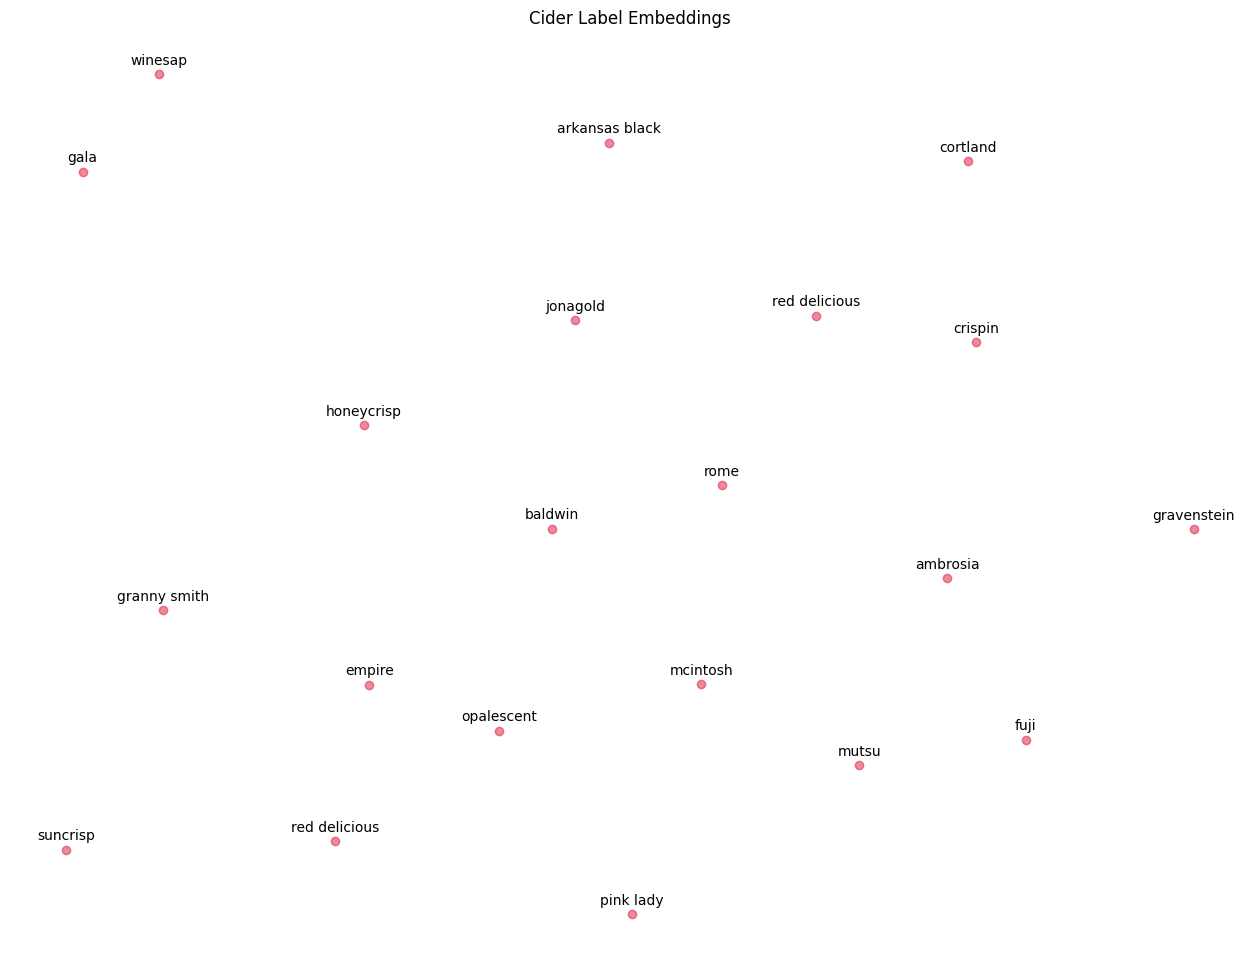

In [12]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.scatter(Y[:, 0], Y[:, 1], color="crimson", alpha=0.5)
for cl, xy in zip(labels, Y):
    ax.annotate(cl.apple, xy=xy, textcoords="offset points", xytext=(0, 7), ha="center")
ax.set_title("Cider Label Embeddings")
ax.axis("off");